### Import

In [1]:
# general imports 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
sns.set()

# model
from sklearn.tree import DecisionTreeClassifier

# optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# shap
import shap
shap.initjs()

# utils
from utils import *

In [2]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)

### Tune For Recall

In [3]:
def create_model(trial):
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    zero_weight = trial.suggest_float('zero_weight', 0, 1)
    class_weight = {0: zero_weight, 1: 1-zero_weight}
    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state = 20,
        class_weight = class_weight
        )
    return model

In [4]:
from sklearn.model_selection import cross_val_score, KFold
def model_performance(model, X = X_train, y = y_train):
    scores = cross_val_score(model, X, y, 
                             cv=KFold(n_splits=10,
                                      shuffle=True,
                                      random_state=20),
                             scoring="recall"
                            )
    # Return the mean of 10 scores
    return scores.mean()
def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance(model)

In [5]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)

In [6]:
trial = study.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 42
	params: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'zero_weight': 0.001235057888855813}
	values: [0.9976218195472484]


In [7]:
best_params = study.best_trial.params
zero_weight = best_params['zero_weight']
one_weight = 1-zero_weight
best_params['class_weight'] = {0: zero_weight, 1: one_weight}
best_params.pop('zero_weight')
best_params

{'max_depth': 5,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'class_weight': {0: 0.001235057888855813, 1: 0.9987649421111442}}

In [8]:
dt = DecisionTreeClassifier(**best_params)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_valid)
get_scores(y_valid, y_pred)

Precision: 0.077
Accuracy: 0.490
Recall: 0.694
F1: 0.139
Fbeta: 0.267
ROC AUC: 0.586
PR AUC: 0.072


<AxesSubplot: title={'center': 'Tuned for recall'}, xlabel='Predictions', ylabel='True Labels'>

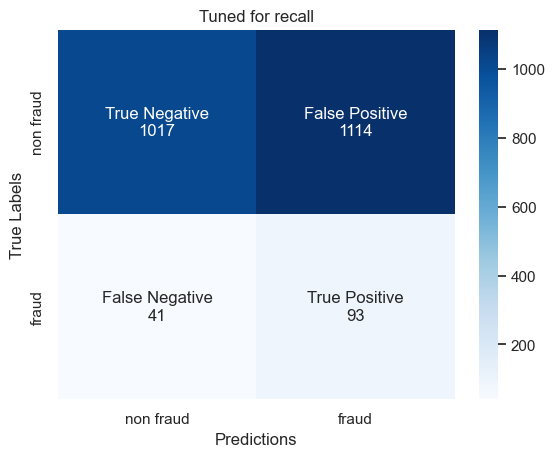

In [9]:

get_confusion_matrix(y_valid, y_pred,'Tuned for recall')

### Tune For fbeta

In [10]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [11]:
def model_performance(model, X = X_train, y = y_train):
    scores = cross_val_score(model, X, y, 
                             cv=KFold(n_splits=10,
                                      shuffle=True,
                                      random_state=20),
                             scoring=ftwo_scorer
                            )
    # Return the mean of 10 scores
    return scores.mean()

def objective(trial):
    model = create_model(trial)
    return model_performance(model)

In [12]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)


In [13]:
trial = study.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 36
	params: {'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 6, 'zero_weight': 0.292112940535598}
	values: [0.9416159762324794]


In [14]:
best_params = study.best_trial.params
zero_weight = best_params['zero_weight']
one_weight = 1-zero_weight
best_params['class_weight'] = {0: zero_weight, 1: one_weight}
best_params.pop('zero_weight')
best_params

{'max_depth': 11,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'class_weight': {0: 0.292112940535598, 1: 0.707887059464402}}

In [15]:
dt = DecisionTreeClassifier(**best_params)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_valid)
get_scores(y_valid, y_pred)


Precision: 0.093
Accuracy: 0.520
Recall: 0.813
F1: 0.167
Fbeta: 0.319
ROC AUC: 0.658
PR AUC: 0.087


<AxesSubplot: title={'center': 'Tuned for fbeta'}, xlabel='Predictions', ylabel='True Labels'>

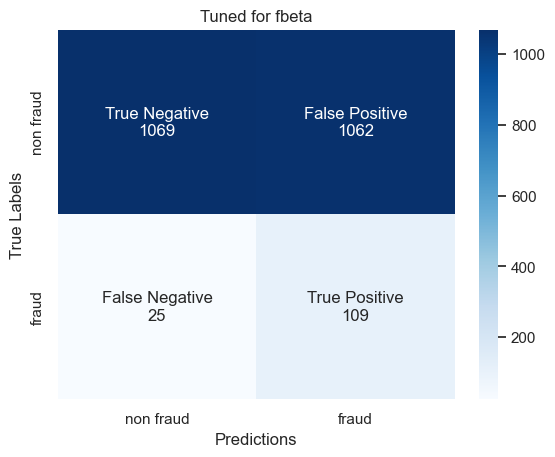

In [16]:

get_confusion_matrix(y_valid, y_pred,'Tuned for fbeta')

### Try feature selection

In [17]:
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()

In [18]:
feature_impt = pd.DataFrame({'feature name':features, 'feature importance':dt.feature_importances_})
not_impt = feature_impt.sort_values('feature importance').iloc[0:5,:]
print(not_impt)

              feature name  feature importance
26             Make_Jaguar                 0.0
41     MaritalStatus_Widow                 0.0
38  MaritalStatus_Divorced                 0.0
35             Make_Saturn                 0.0
34               Make_Saab                 0.0


Variables
PolicyType_Sedan - Liability    0.379480
Fault_IsPolicyholder            0.250084
AddressChange_Claim             0.065779
MonthClaimed                    0.042039
PolicyType_Sedan - Collision    0.035124
Year                            0.034903
Make_Pontiac                    0.033995
AgeOfVehicle                    0.019082
Normalised_Age                  0.015655
Sex_IsMale                      0.013250
Name: Importance, dtype: float64


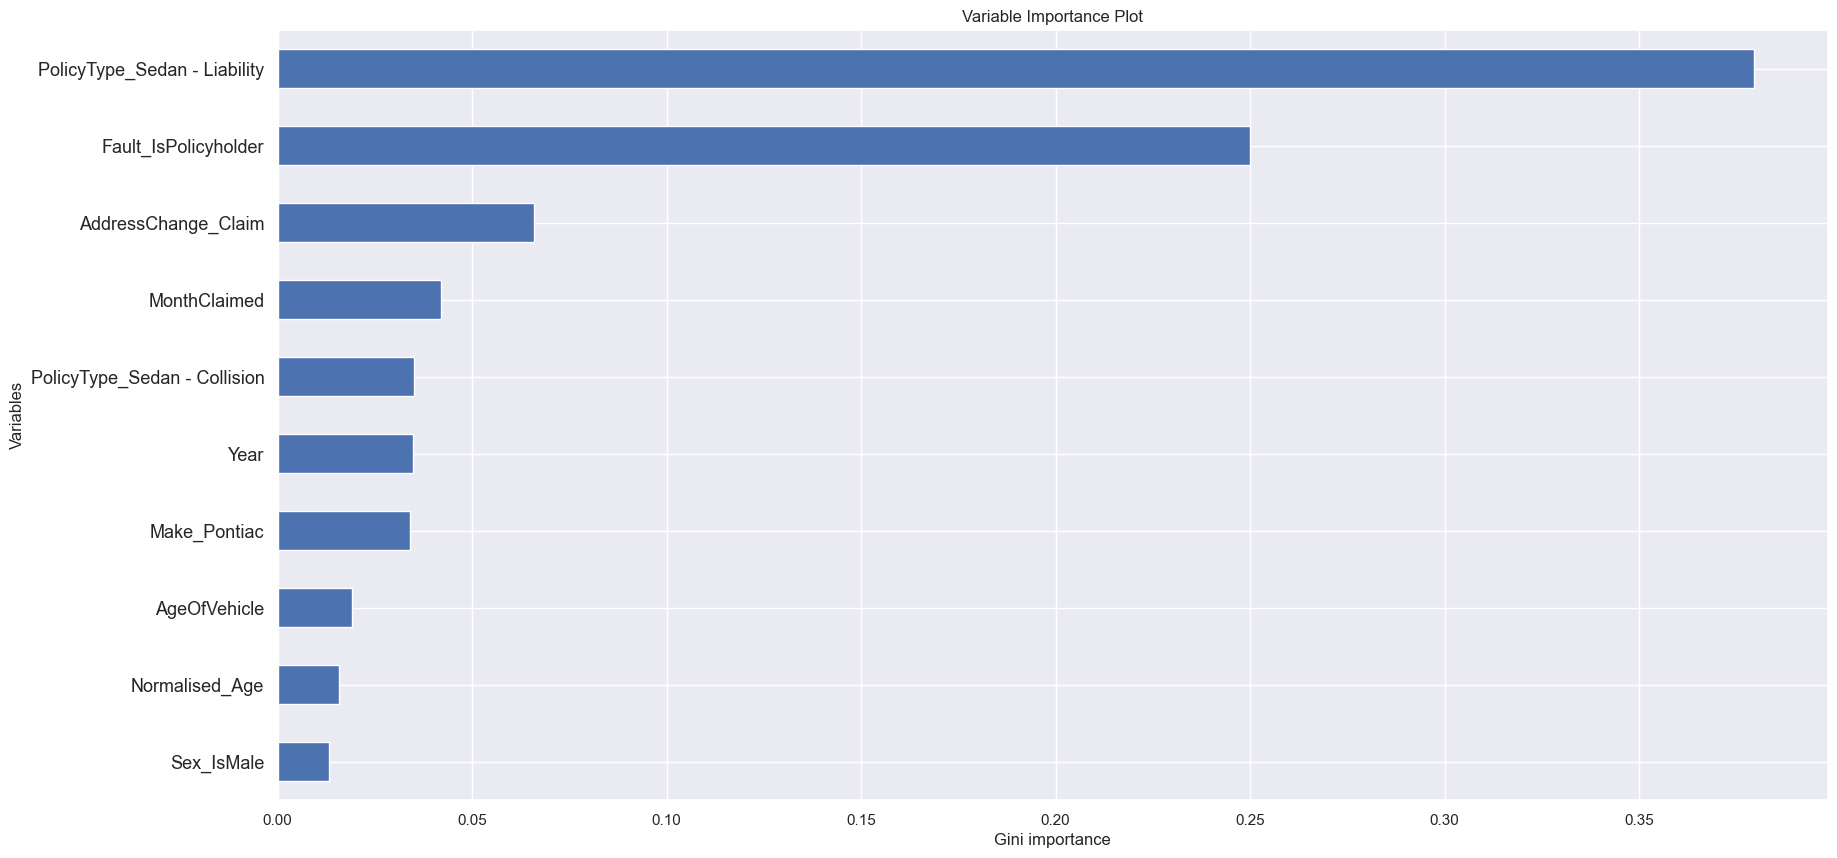

In [19]:
import matplotlib.pyplot as plt
model_ranks = pd.Series(dt.feature_importances_, index=features, name='Importance').sort_values(ascending=False, inplace=False)
model_ranks.index.name = 'Variables'
top_features = model_ranks.iloc[:10].sort_values(ascending=True, inplace=False)
plt.figure(figsize=(20,10))
ax = top_features.plot(kind='barh')
ax.set_title('Variable Importance Plot')
ax.set_xlabel('Gini importance')
ax.set_yticklabels(top_features.index, fontsize=13)

print(top_features.sort_values(ascending=False))

In [20]:
# remove feature importance == 0
df_train = df_train.drop(not_impt['feature name'], axis = 1)
df_valid = df_valid.drop(not_impt['feature name'], axis = 1)
df_test = df_test.drop(not_impt['feature name'], axis = 1)

X_train = df_train.drop('FraudFound_P', axis=1)
X_valid = df_valid.drop('FraudFound_P', axis=1)
X_test = df_test.drop('FraudFound_P', axis=1)

y_train = df_train['FraudFound_P']
y_valid = df_valid['FraudFound_P']
y_test = df_test['FraudFound_P']

In [21]:
df_train.columns

Index(['MonthClaimed', 'VehiclePrice', 'FraudFound_P', 'Deductible',
       'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'AccidentArea_IsUrban', 'Sex_IsMale', 'Fault_IsPolicyholder',
       'PoliceReportFiled_IsYes', 'WitnessPresent_IsYes',
       'AgentType_IsExternal', 'isWithinAgeRange_IsTrue', 'Make_Accura',
       'Make_BMW', 'Make_Chevrolet', 'Make_Dodge', 'Make_Ford', 'Make_Honda',
       'Make_Lexus', 'Make_Mazda', 'Make_Mecedes', 'Make_Mercury',
       'Make_Nisson', 'Make_Pontiac', 'Make_Porche', 'Make_Toyota', 'Make_VW',
       'MaritalStatus_Married', 'MaritalStatus_Single',
       'PolicyType_Sedan - All Perils', 'PolicyType_Sedan - Collision',
       'PolicyType_Sedan - Liability', 'PolicyType_Sport - All Perils',
       'PolicyType_Sport - Collision', 'PolicyType_Utility - All Perils',
       'PolicyType_Uti

In [22]:
def create_model(trial):
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    zero_weight = trial.suggest_float('zero_weight', 0, 1)
    class_weight = {0: zero_weight, 1: 1-zero_weight}
    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state = 20,
        class_weight = class_weight
        )
    return model
def model_performance(model, X = X_train, y = y_train):
    scores = cross_val_score(model, X, y, 
                             cv=KFold(n_splits=10,
                                      shuffle=True,
                                      random_state=20),
                             scoring=ftwo_scorer
                            )
    # Return the mean of 10 scores
    return scores.mean()

def objective(trial):
    model = create_model(trial)
    return model_performance(model)

In [23]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)

In [24]:
trial = study.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 42
	params: {'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 6, 'zero_weight': 0.09701094161842233}
	values: [0.4278056180389399]


In [25]:
best_params = study.best_trial.params
zero_weight = best_params['zero_weight']
one_weight = 1-zero_weight
best_params['class_weight'] = {0: zero_weight, 1: one_weight}
best_params.pop('zero_weight')
best_params

{'max_depth': 9,
 'min_samples_split': 3,
 'min_samples_leaf': 6,
 'class_weight': {0: 0.09701094161842233, 1: 0.9029890583815776}}

In [26]:
dt = DecisionTreeClassifier(**best_params)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_valid)

get_scores(y_valid, y_pred)

Precision: 0.101
Accuracy: 0.527
Recall: 0.881
F1: 0.180
Fbeta: 0.345
ROC AUC: 0.693
PR AUC: 0.096


<AxesSubplot: title={'center': 'After feature selection'}, xlabel='Predictions', ylabel='True Labels'>

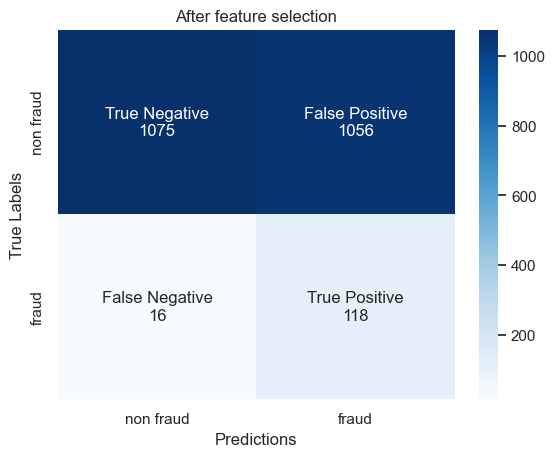

In [27]:
get_confusion_matrix(y_valid, y_pred,'After feature selection')

### SHAP

In [36]:
import shap
# Fits the explainer
explainer = shap.Explainer(dt.predict, X_train, seed=0)
shap_values = explainer(X_train.values[1:1000,:])

Permutation explainer: 1000it [00:58, 15.58it/s]                        


In [40]:
#creating a feature list
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()

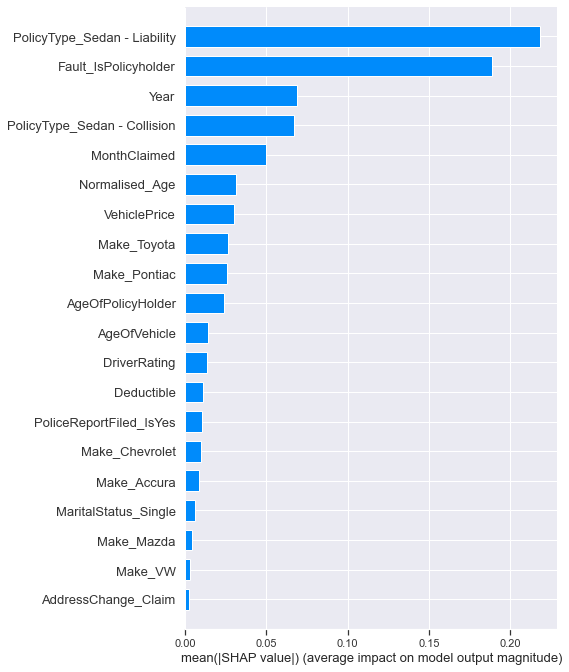

In [41]:
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=features)

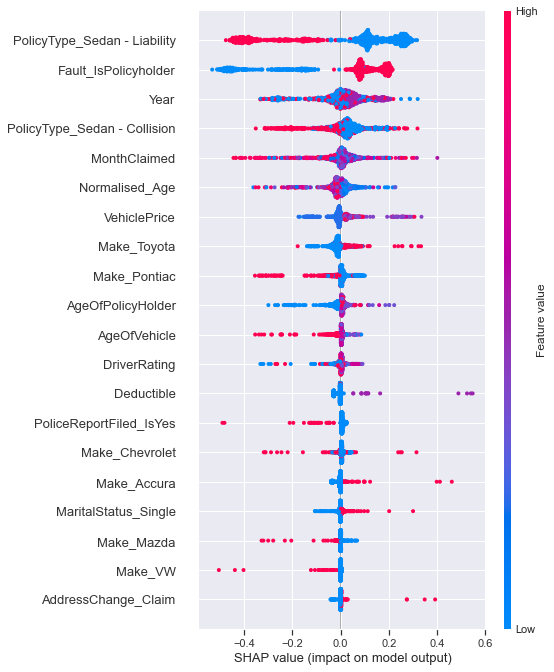

In [44]:
shap.summary_plot(shap_values, X_train.values[1:1000,:], features)